### Library import & Data Load

In [ ]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 전처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD, FastICA
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection


import warnings
warnings.filterwarnings(action='ignore') 

seed 고정

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(69) # Seed 고정

- train_data: 학습용 데이터로 모두 정상 case로 이루어진 데이터입니다.
- test_data: 평가용 데이터로 정상 case와 이상 case가 함께 포함되어 있는 데이터로, 예측 대상에 해당됩니다.
- answer_sample: test_data에 대하여 작성할 제출용 레이블 파일 양식입니다.

- air_inflow: 공기 흡입 유량 (^3/min)
- air_end_temp: 공기 말단 온도 (°C)
- out_pressure: 토출 압력 (Mpa)
- motor_current: 모터 전류 (A)
- motor_rpm: 모터 회전수 (rpm)
- motor_temp: 모터 온도 (°C)
- motor_vibe: 모터 진동 (mm/s)
- type: 설비 번호

설비별로 다음의 특성을 갖습니다.

- 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)

- 설비 번호 1: 20HP

- 설비 번호 2: 10HP

- 설비 번호 3: 50HP

data load

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/AIFactory/train_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/AIFactory/test_data.csv")
train_df.head()

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0        1.59         41.00           0.7          20.53     1680.0   
1        2.97         59.28           0.7          38.40     3142.0   
2        1.91         45.29           0.7          24.73     2023.0   
3        2.37         51.33           0.7          30.63     2506.0   
4        1.90         45.21           0.7          24.65     2017.0   

   motor_temp  motor_vibe  type  
0       58.67        2.93     0  
1       74.91        3.75     0  
2       62.48        3.12     0  
3       67.84        3.39     0  
4       62.41        3.12     0

In [ ]:
test_df.head()

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0        2.51         53.28           0.7          32.54     2662.0   
1        2.66         55.24           0.7          34.45     2819.0   
2        1.72         42.74           0.7          22.23     1819.0   
3        2.20         49.15           0.7          28.50     2332.0   
4        2.06         47.28           0.7          26.67     2182.0   

   motor_temp  motor_vibe  type  
0       69.58        3.48     0  
1       71.32        3.57     0  
2       60.21        3.01     0  
3       65.91        3.30     0  
4       64.24        3.21     0

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


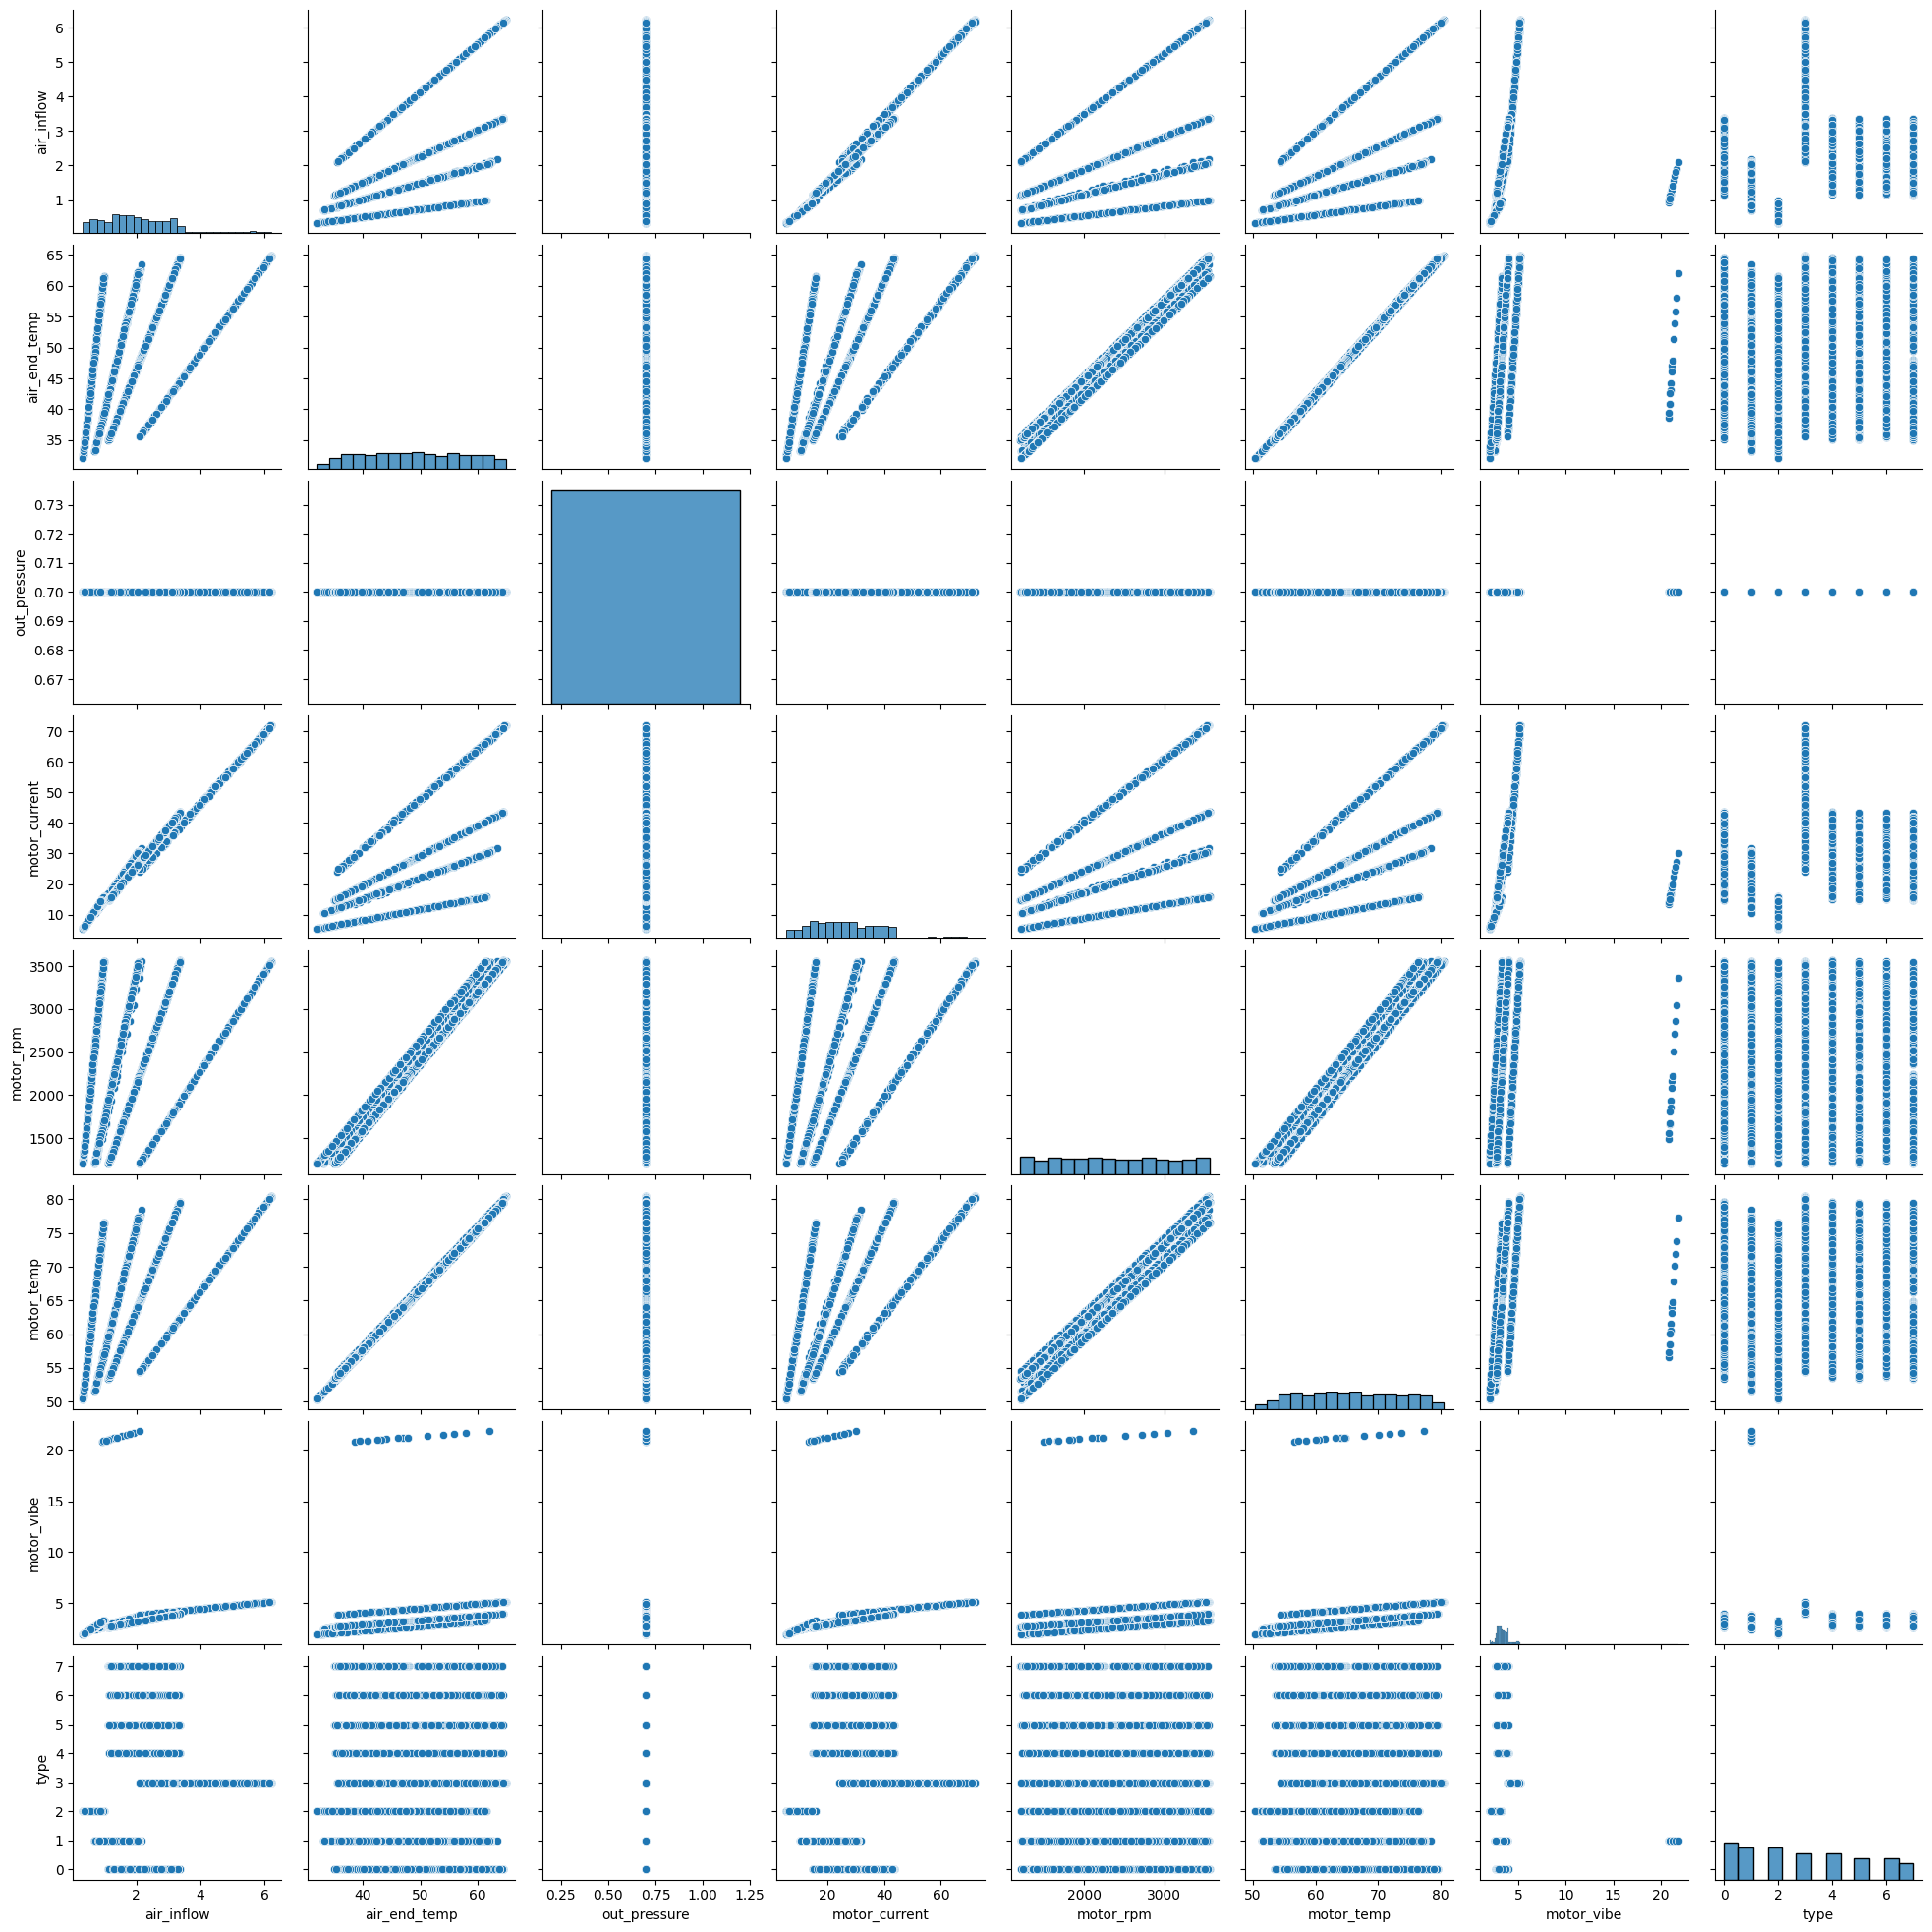

In [ ]:
sns.pairplot(train_df)

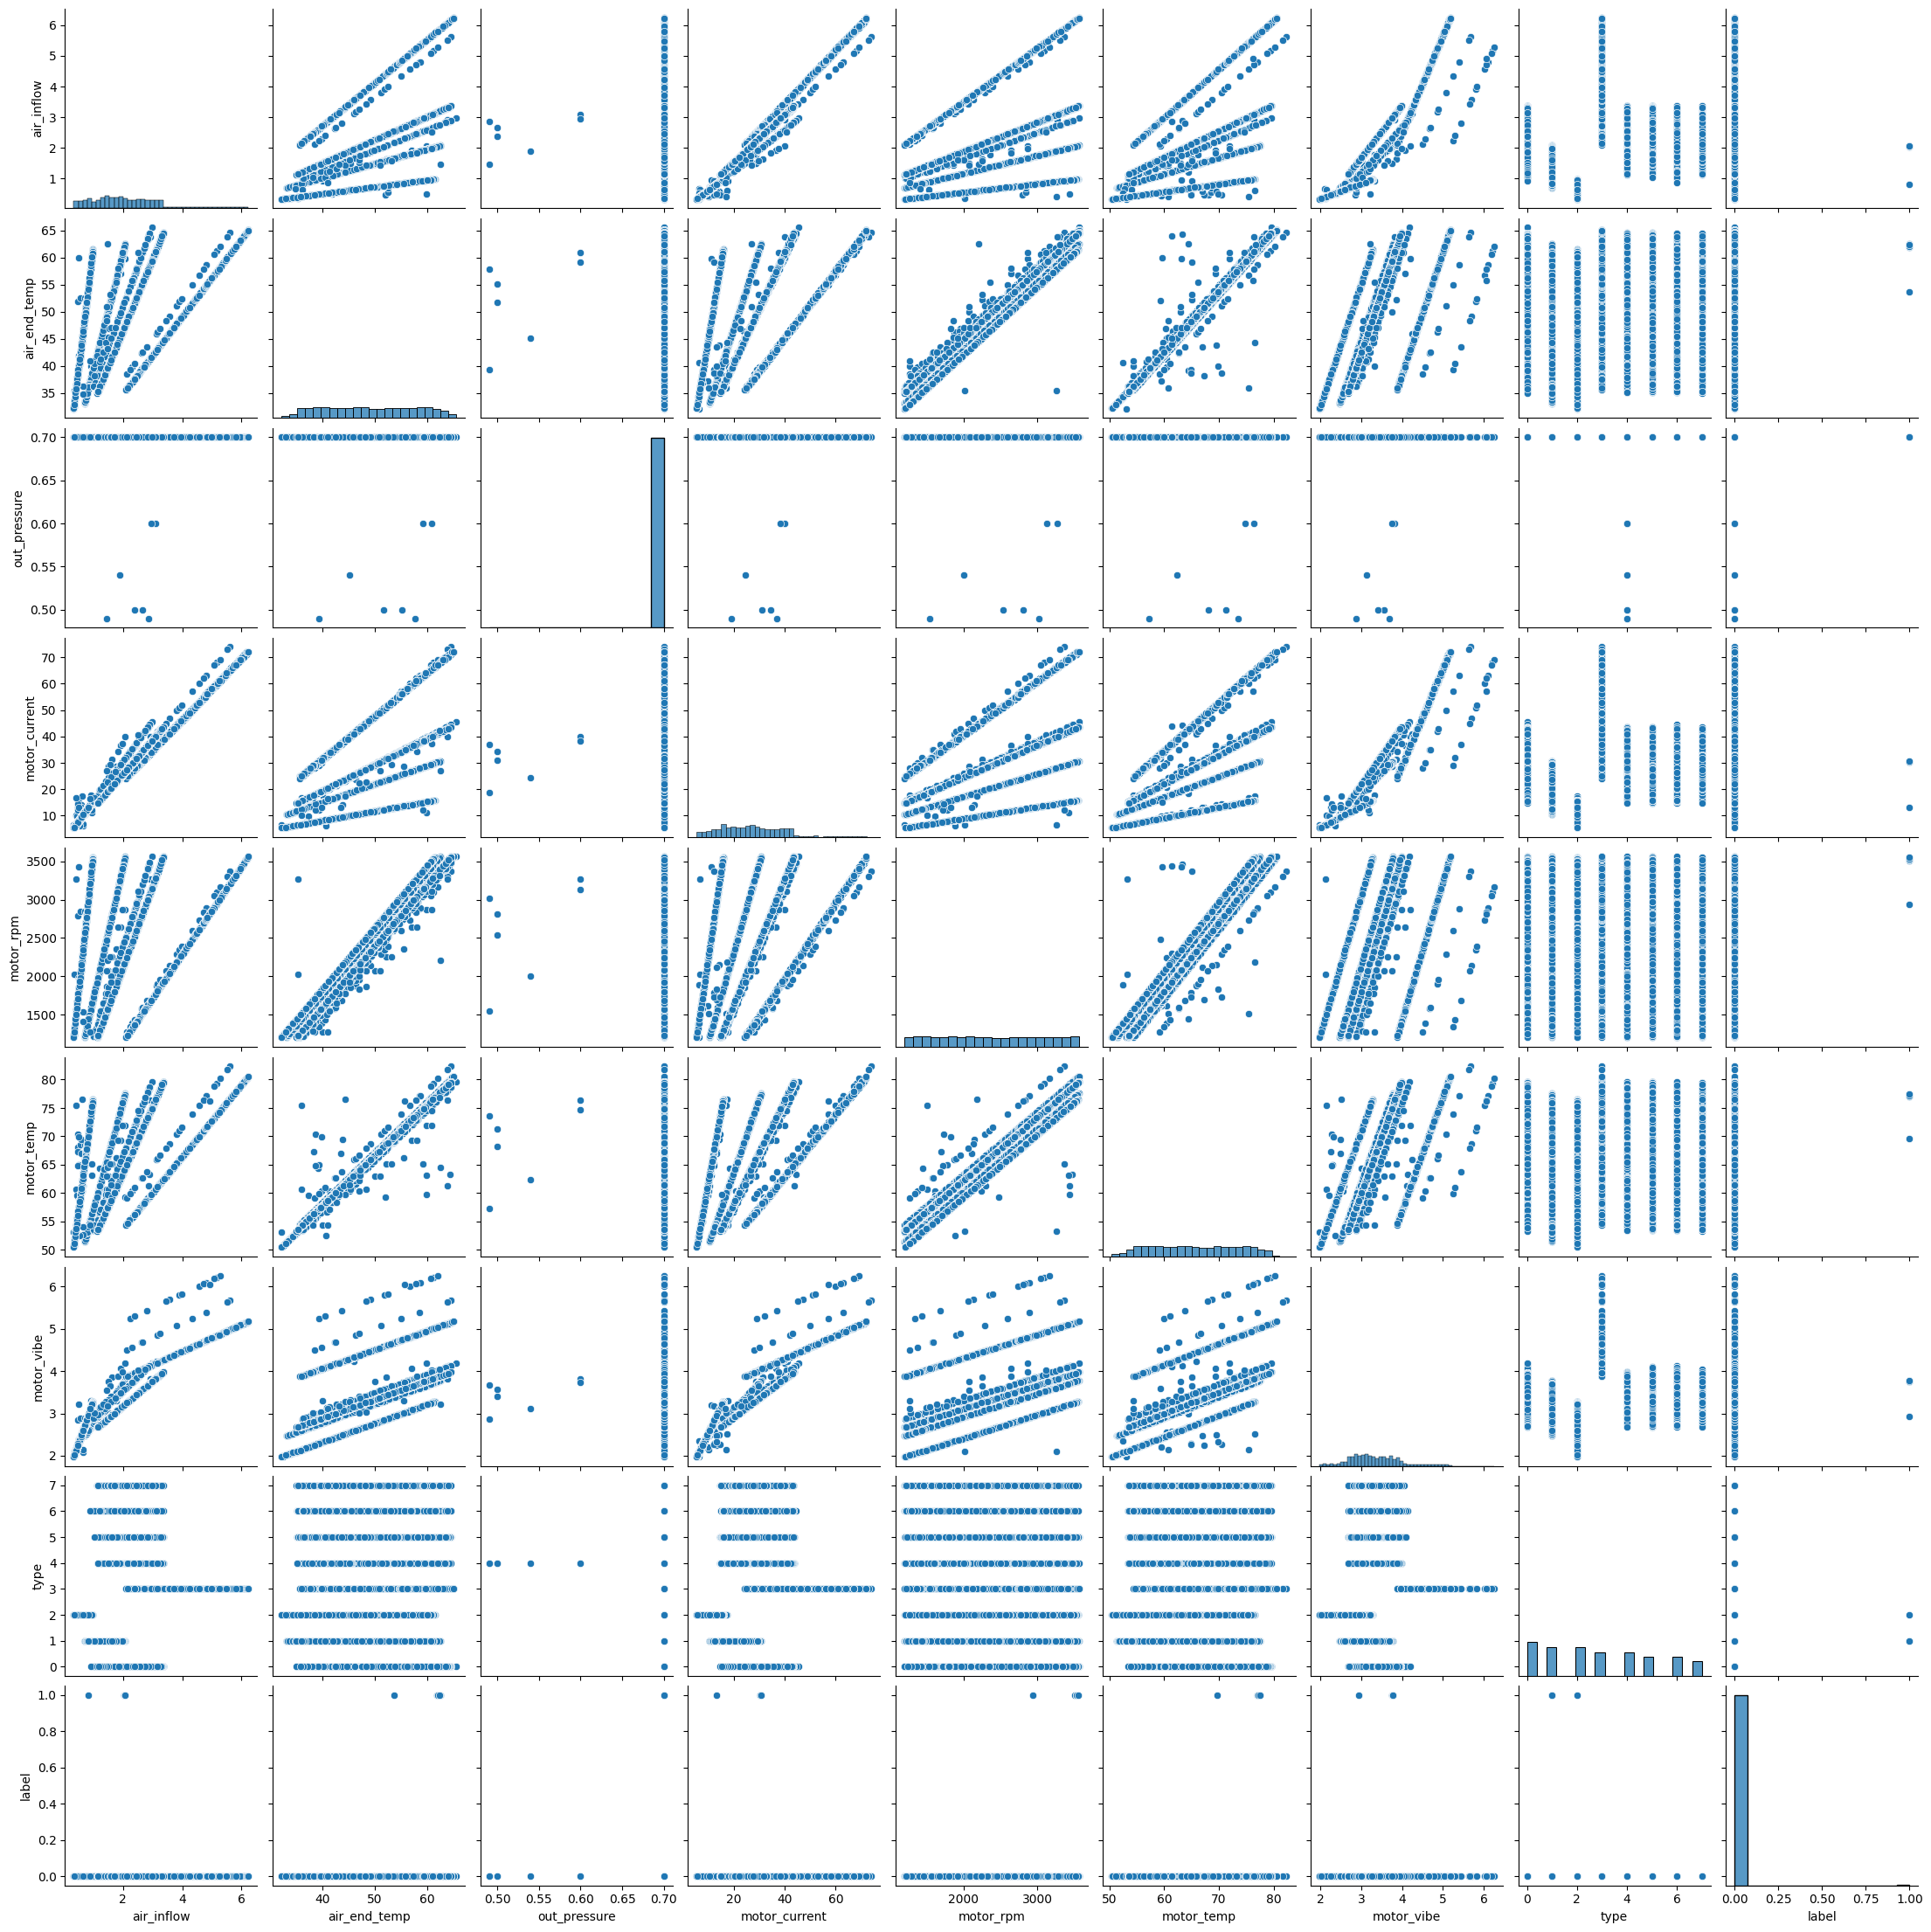

In [ ]:
sns.pairplot(test_df)

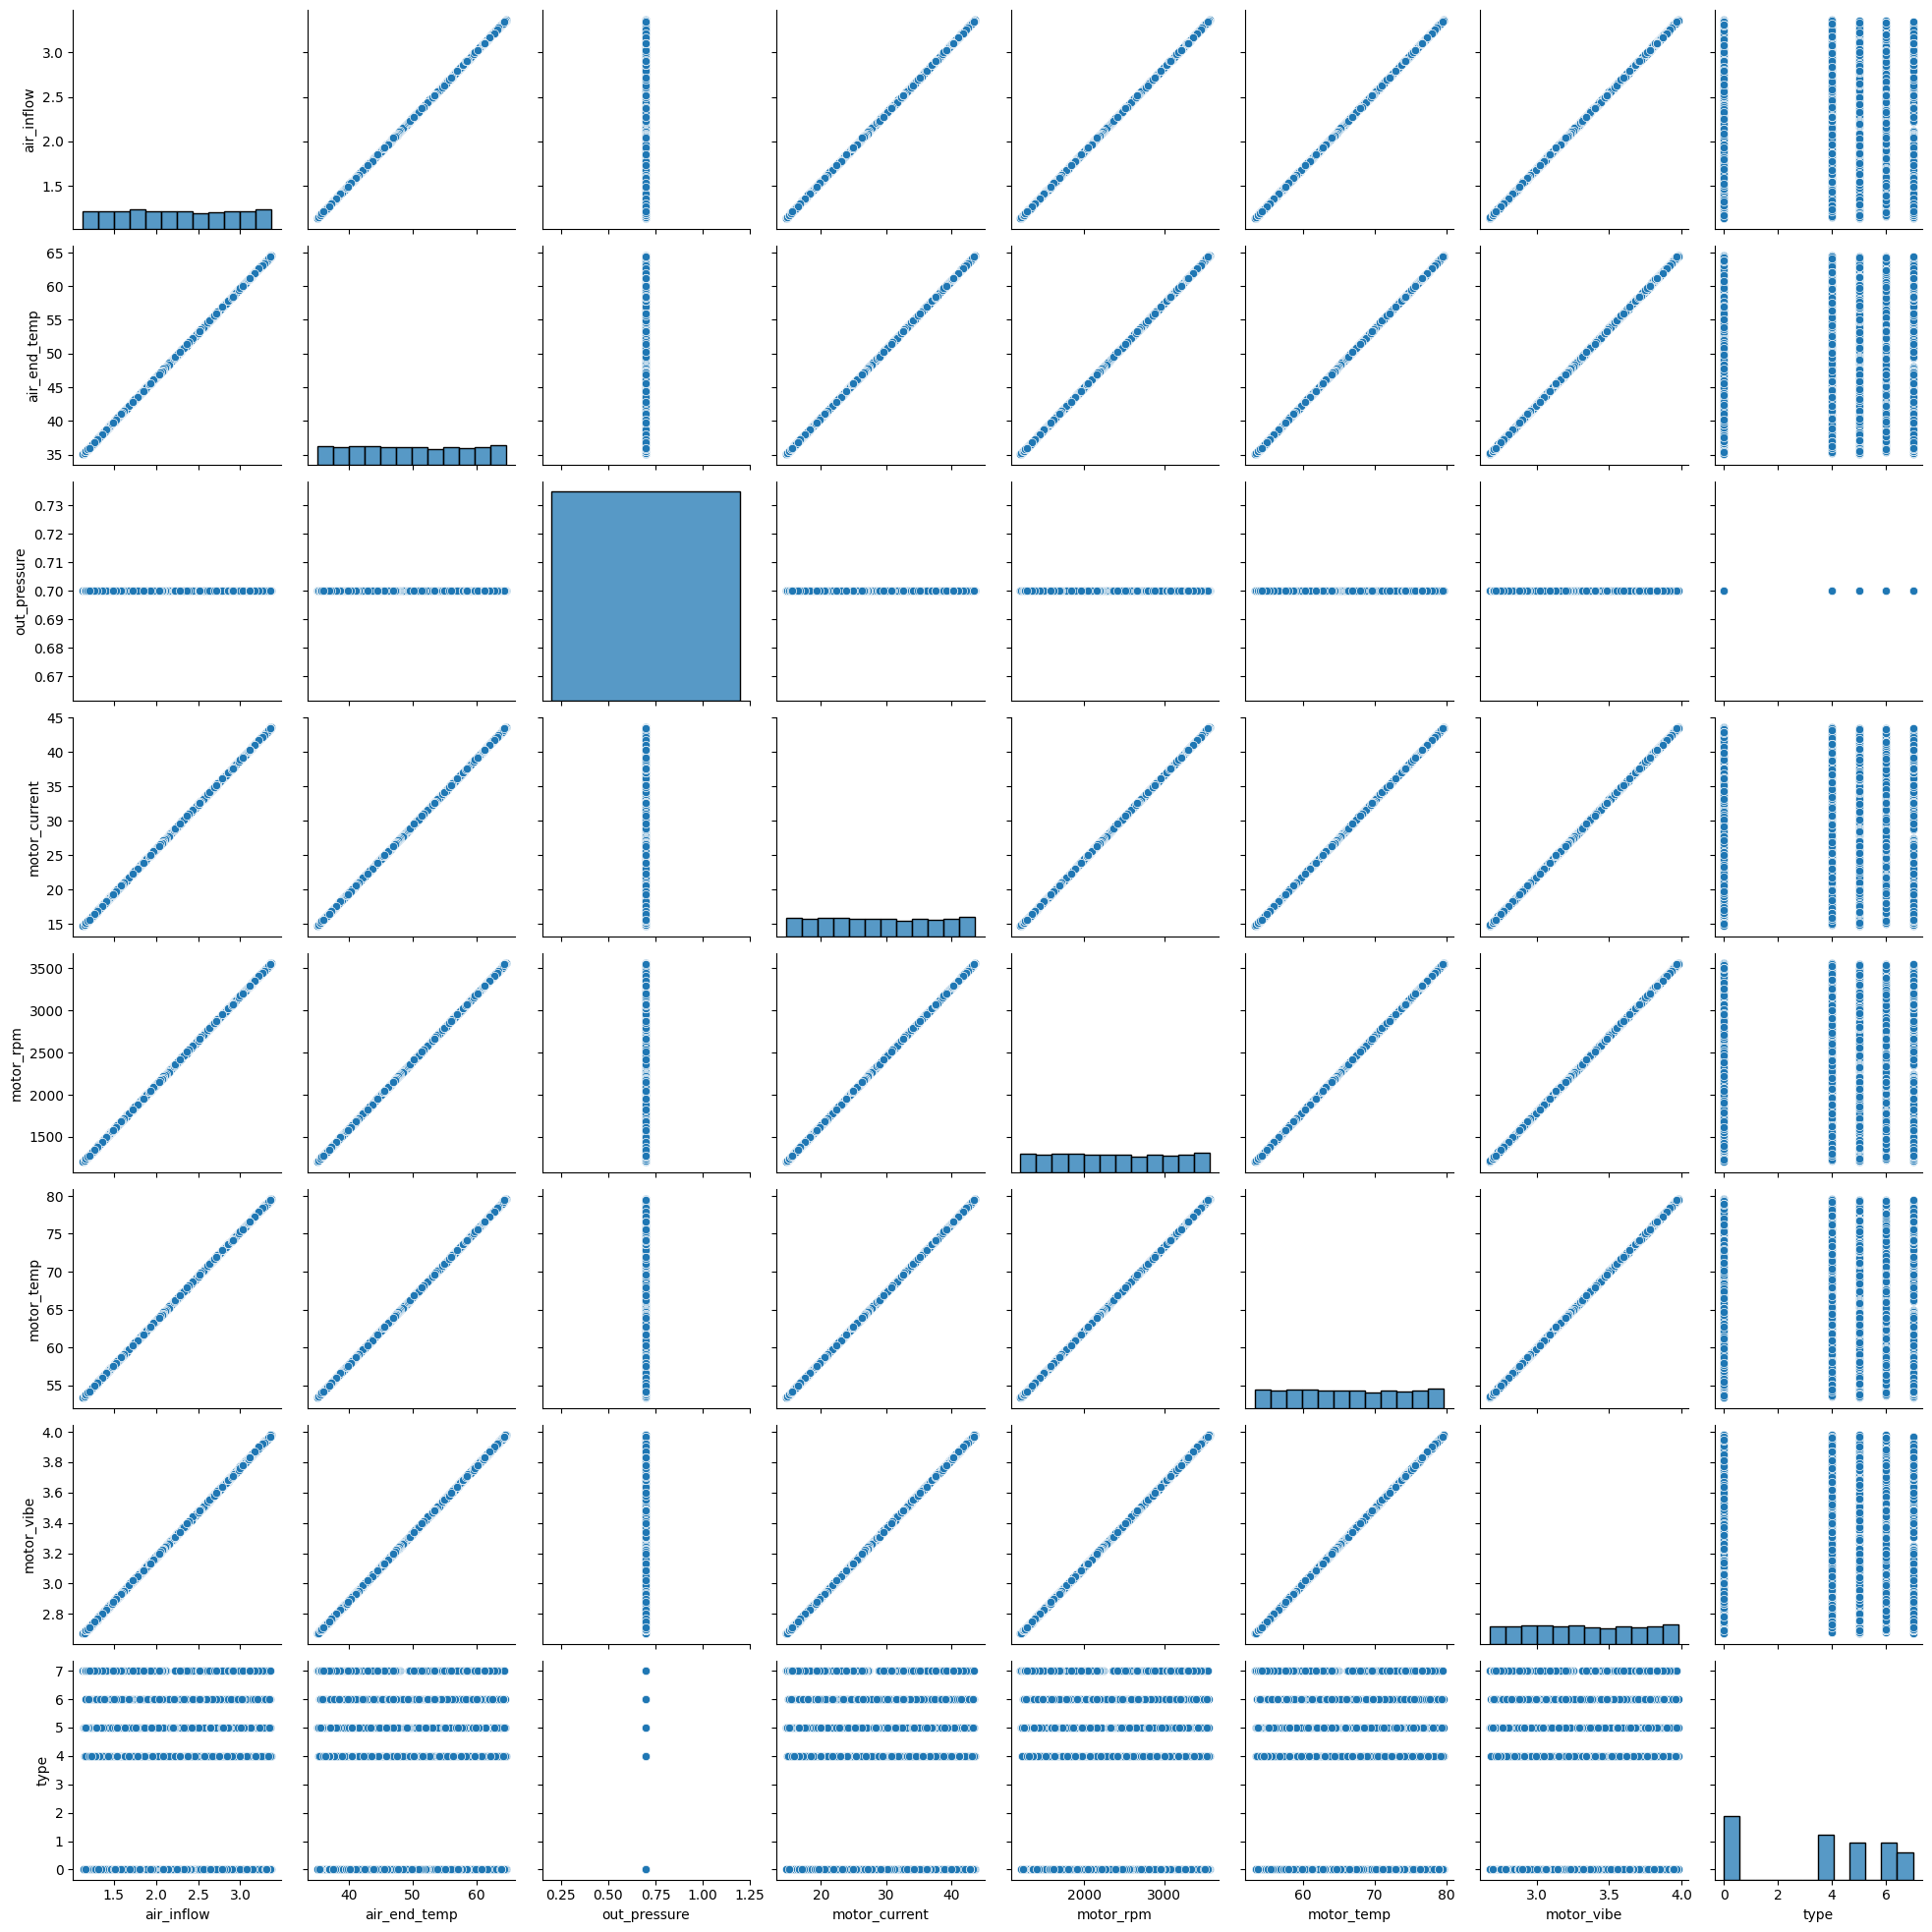

In [ ]:
sns.pairplot(train_df.loc[train_df["type"].isin([0,4,5,6,7])])

### 변수별 histogram

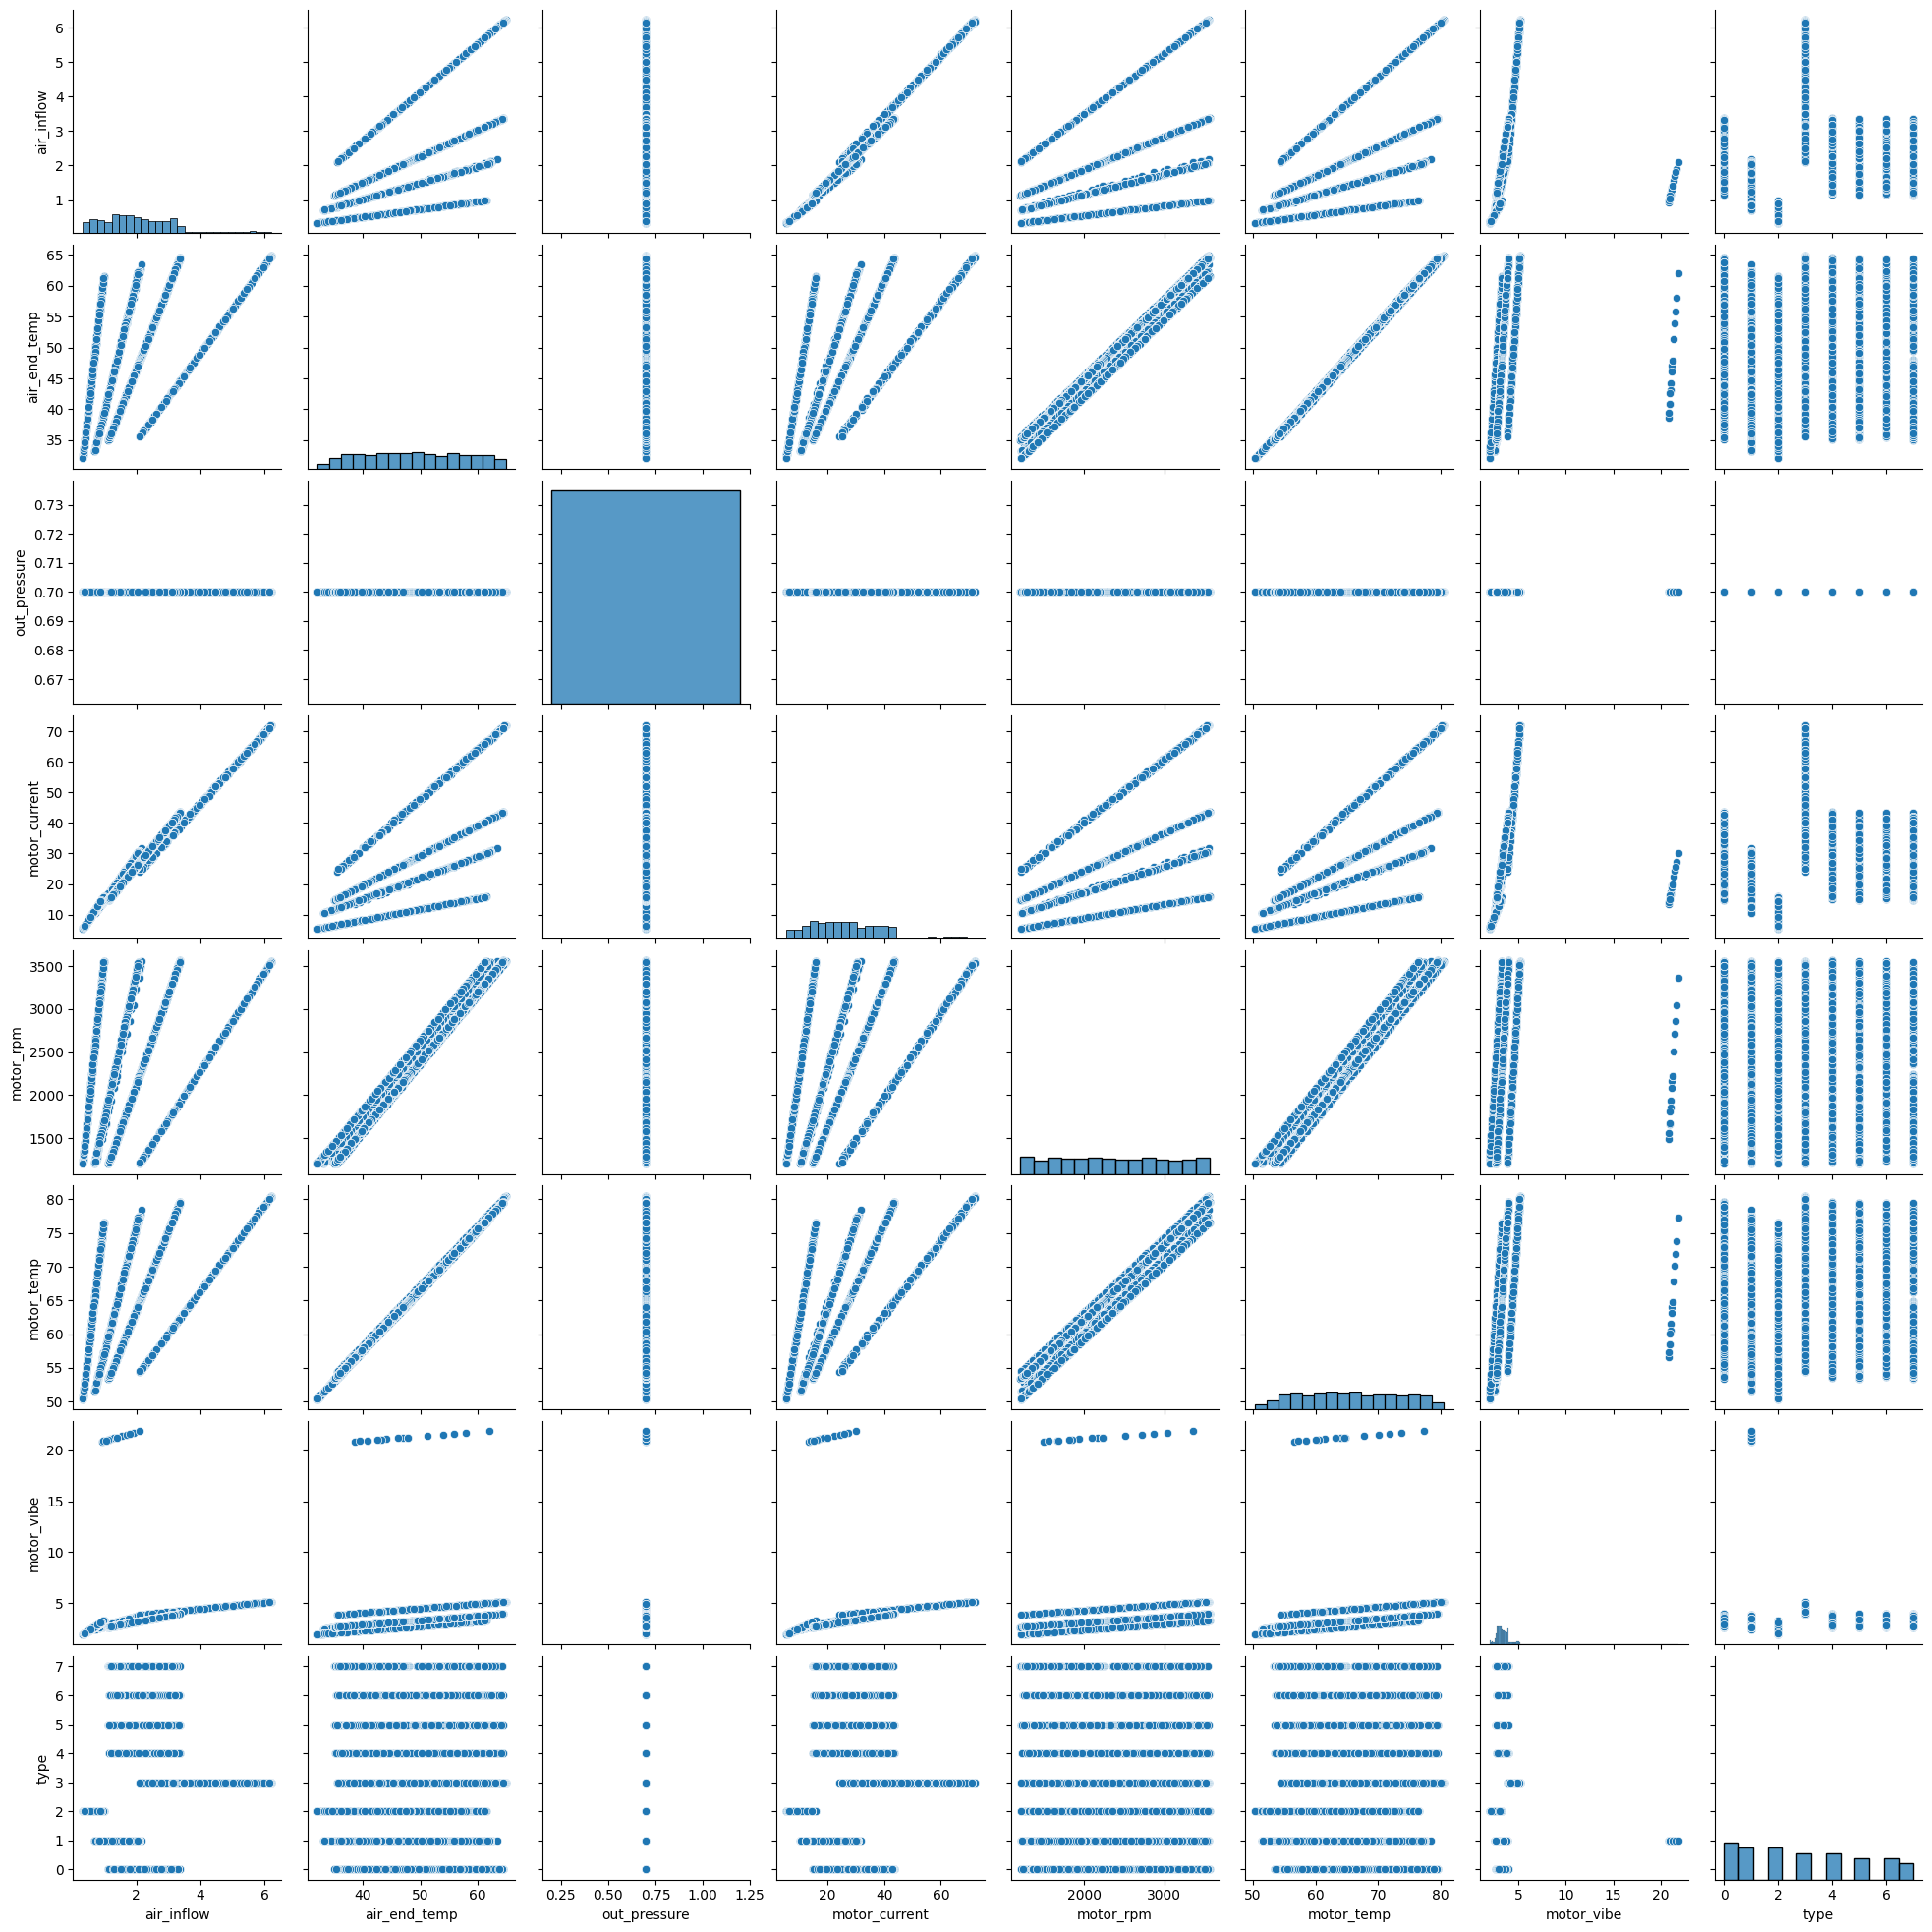

In [ ]:
sns.pairplot(train_df, diag_kind = 'auto')

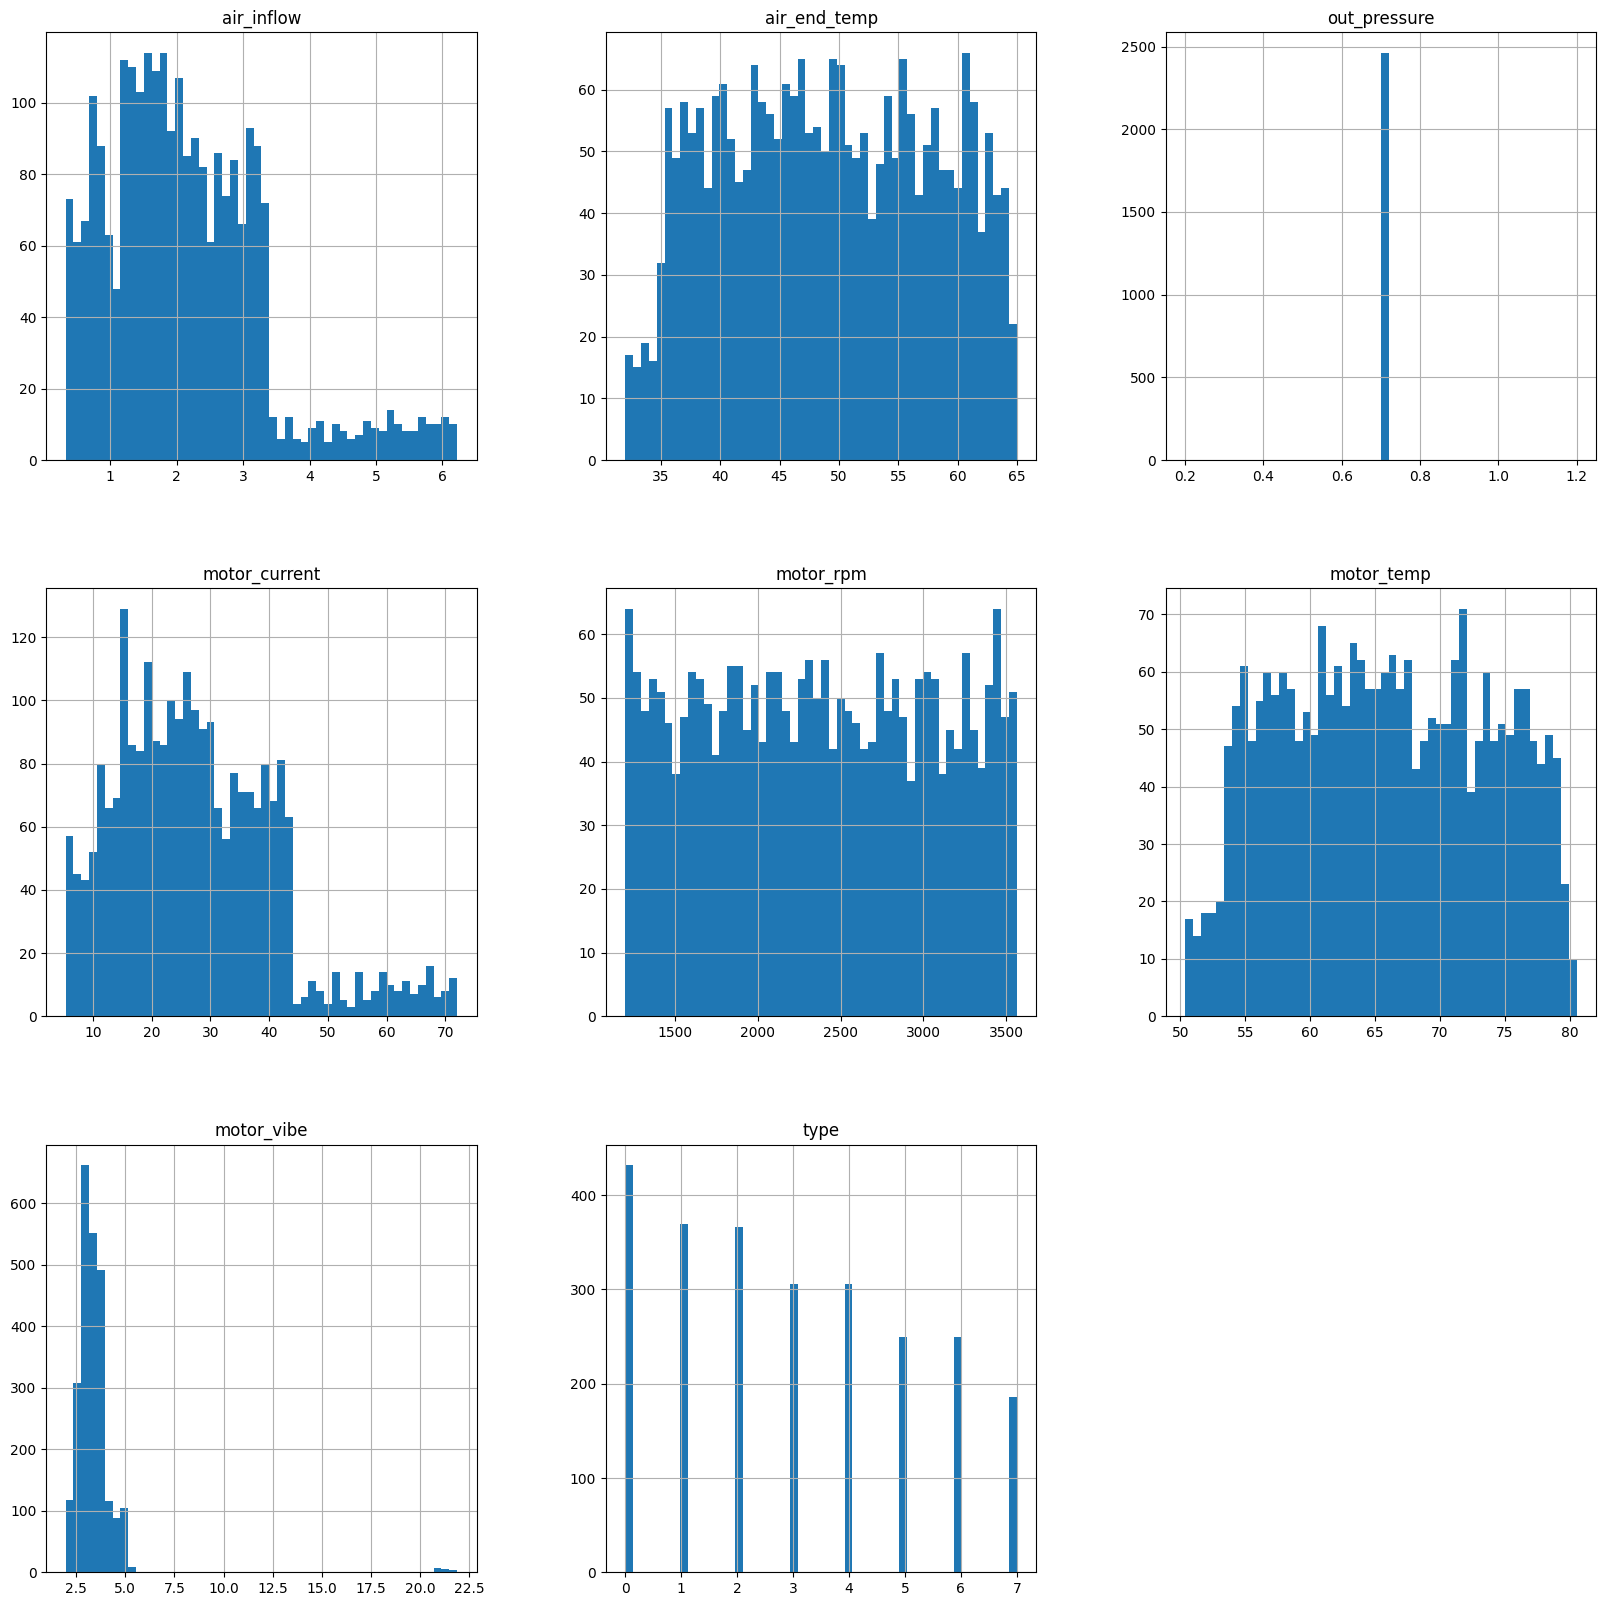

In [ ]:
train_df.hist(bins = 50, figsize = (20,20))
plt.show()

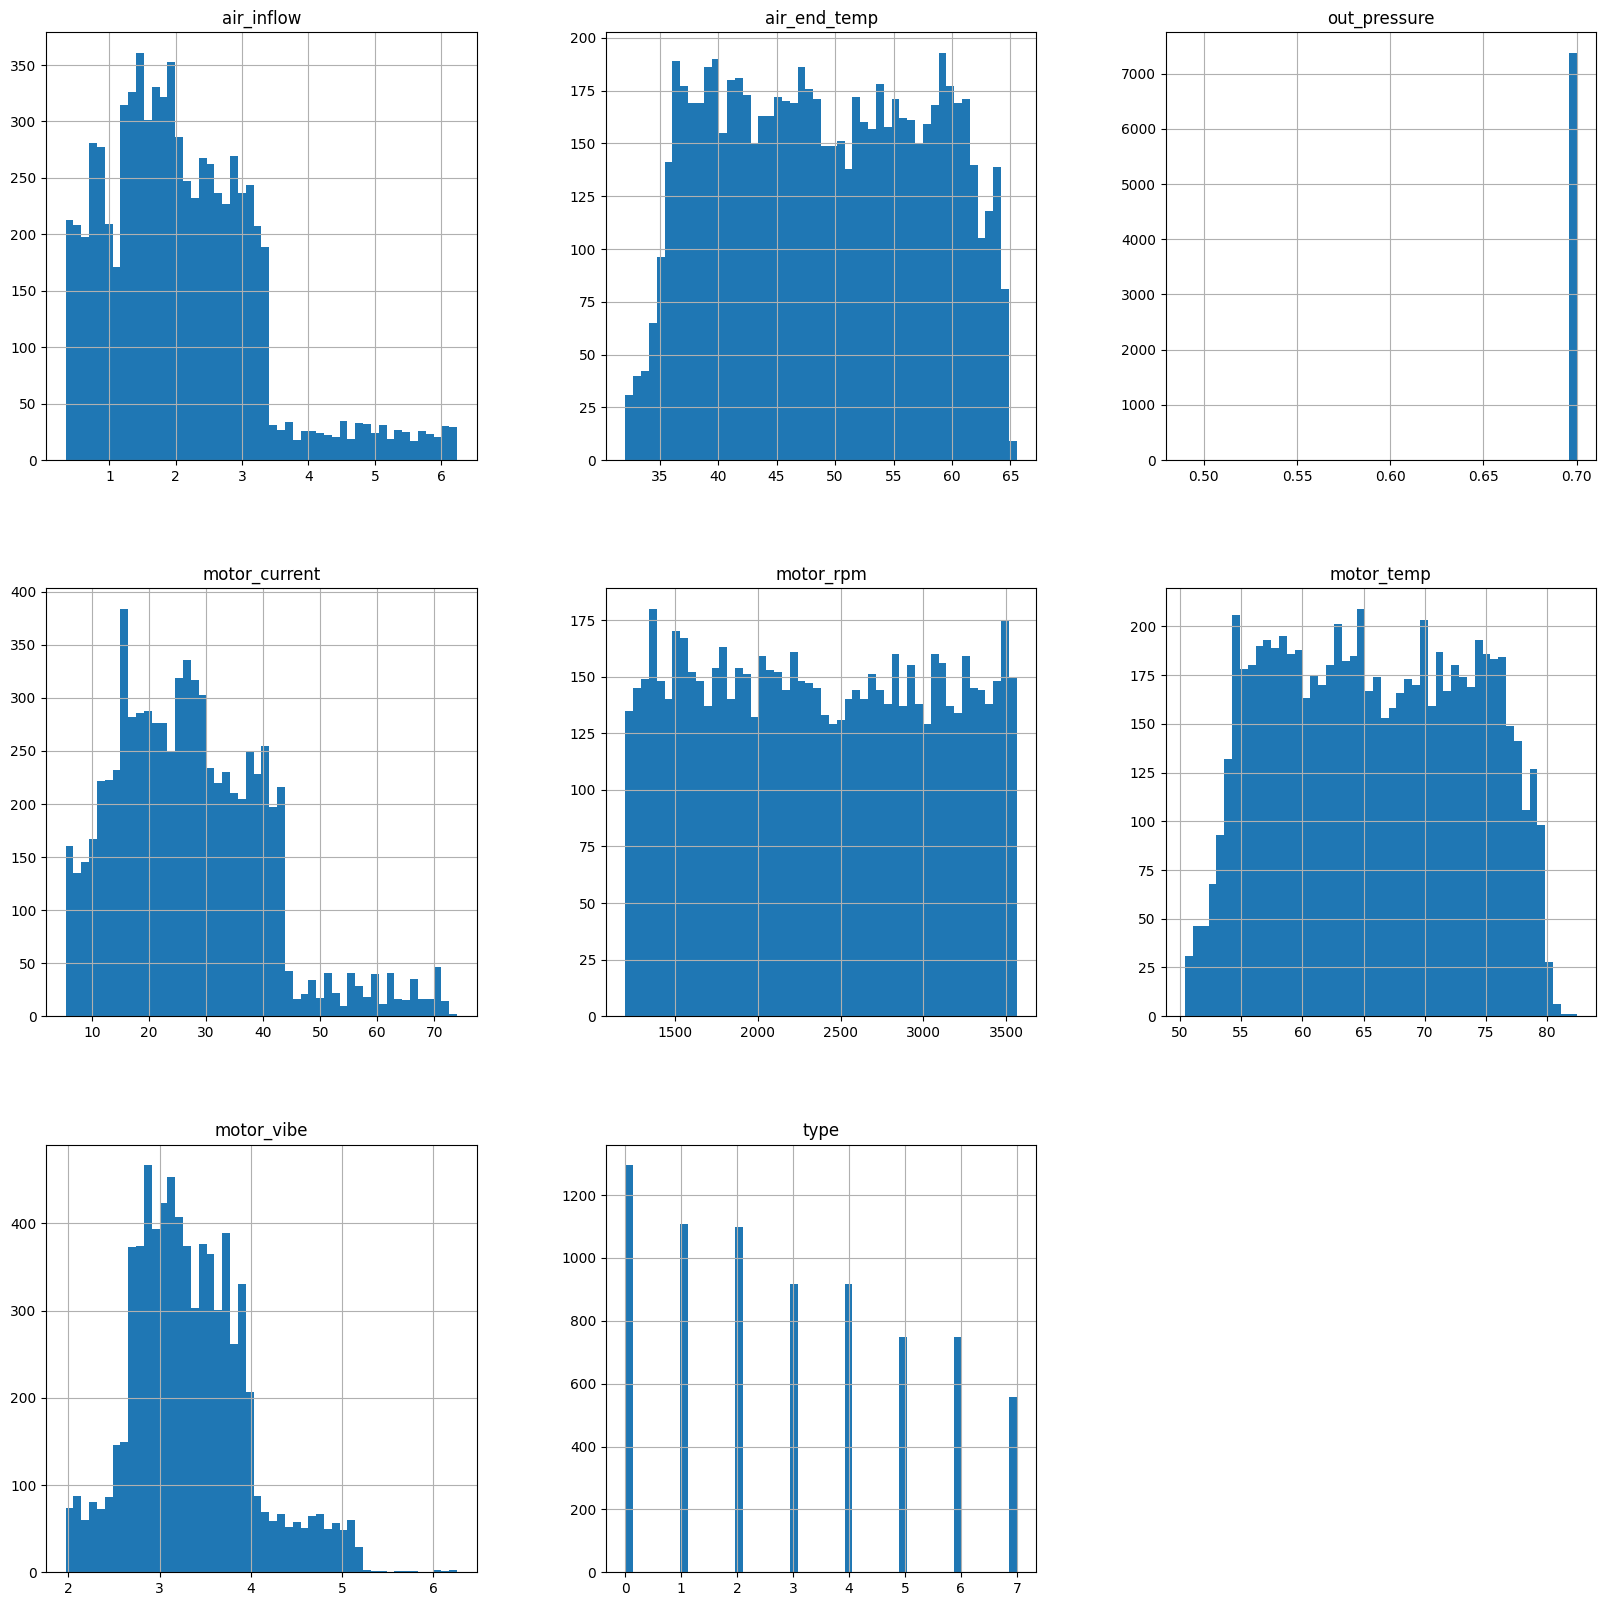

In [ ]:
test_df.hist(bins = 50, figsize = (20,20))
plt.show()

### 설비번호 별(0~7)로 데이터 split 후 minmax_scaler + Isolation Forest + predict (지금까지 제일 높음) 0.5429

In [ ]:
# Train dataset, Test dataset은 Label이 존재하지 않음
train_x = train_df # Input Data
test_x = test_df

# 설비 번호 별로 데이터 분류
def type_split(Data):
    type_0 = Data.loc[Data["type"] == 0]
    type_1 = Data.loc[Data["type"] == 1]
    type_2 = Data.loc[Data["type"] == 2]
    type_3 = Data.loc[Data["type"] == 3]
    type_4 = Data.loc[Data["type"] == 4]
    type_5 = Data.loc[Data["type"] == 5]
    type_6 = Data.loc[Data["type"] == 6]
    type_7 = Data.loc[Data["type"] == 7]
    return type_0, type_1, type_2, type_3, type_4, type_5, type_6, type_7

train_type_0, train_type_1, train_type_2, train_type_3, train_type_4, train_type_5, train_type_6, train_type_7 = type_split(train_x)
test_type_0, test_type_1, test_type_2, test_type_3, test_type_4, test_type_5, test_type_6, test_type_7 = type_split(test_x)

print(train_type_0.shape, train_type_1.shape, train_type_2.shape, train_type_3.shape, train_type_4.shape, train_type_5.shape, train_type_6.shape, train_type_7.shape)

print(test_type_0.shape, test_type_1.shape, test_type_2.shape, test_type_3.shape, test_type_4.shape, test_type_5.shape, test_type_6.shape, test_type_7.shape)

# 정규화 + 모델링 + 예측 함수

num = 0
test_pred = np.zeros(len(test_df))
def IForest(train_type, test_type):
    # MinMaxScaler()
    scaler = MinMaxScaler()
    scaled_train_type = scaler.fit_transform(train_type)
    scaled_test_type = scaler.fit_transform(test_type)

    scaled_train_type = pd.DataFrame(scaled_train_type)
    scaled_test_type = pd.DataFrame(scaled_test_type)
    
    # dimension_reducer
    dimesion_reducer = SparseRandomProjection(n_components=8,
                                          eps=0.1)
    scaled_train_type = dimesion_reducer.fit_transform(scaled_train_type)
    scaled_test_type = dimesion_reducer.transform(scaled_test_type)

    scaled_train_type = pd.DataFrame(scaled_train_type)
    scaled_test_type = pd.DataFrame(scaled_test_type)

    model = IsolationForest(n_estimators=300,
                            max_samples=0.8, 
                            max_features=0.7,
                            contamination=0.00000000000001,
                            verbose=0)   
    model.fit(scaled_train_type)

    global num
    global test_pred

    test_pred[num:num+len(scaled_test_type)] = model.predict(scaled_test_type)
    num += len(scaled_test_type)
    
    return test_pred 

IForest(train_type_0, test_type_0)
IForest(train_type_1, test_type_1)
IForest(train_type_2, test_type_2)
IForest(train_type_3, test_type_3)
IForest(train_type_4, test_type_4)
IForest(train_type_5, test_type_5)
IForest(train_type_6, test_type_6)
IForest(train_type_7, test_type_7)

print(pd.DataFrame(test_pred).value_counts())

def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

test_pred = get_pred_label(test_pred)

submit = pd.read_csv("/content/drive/MyDrive/AIFactory/answer_sample.csv")

submit['label'] = test_pred
print(submit.label.value_counts())

submit.to_csv("/content/drive/MyDrive/AIFactory/submit5.csv", index = False)

(432, 8) (369, 8) (366, 8) (306, 8) (306, 8) (249, 8) (249, 8) (186, 8)
(1296, 8) (1107, 8) (1098, 8) (918, 8) (918, 8) (747, 8) (747, 8) (558, 8)
 1.0    6533
-1.0     856
dtype: int64
0.0    6533
1.0     856
Name: label, dtype: int64


### 설비번호: (0,4,5,6,7) / 1 / 2 / 3  
### 4가지로 분류 + MinMaxScaler + Isolation Forest   0.48 오히려 더 떨어짐 왜지??

In [ ]:
# Train dataset, Test dataset은 Label이 존재하지 않음
train_x = train_df   # Input Data
test_x = test_df

# 설비번호 별로 특성이 다름
# 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
# 설비 번호 1: 20HP
# 설비 번호 2: 10HP
# 설비 번호 3: 50HP

# 설비번호: (0,4,5,6,7) / 1 / 2 / 3  4가지로 분류

def type_split(Data):
    type_04567 = Data.loc[Data["type"].isin([0,4,5,6,7])]
    type_1 = Data.loc[Data["type"] == 1]
    type_2 = Data.loc[Data["type"] == 2]
    type_3 = Data.loc[Data["type"] == 3]
    
    return type_04567, type_1, type_2, type_3

train_type_04567, train_type_1, train_type_2, train_type_3 = type_split(train_x)
test_type_04567, test_type_1, test_type_2, test_type_3 = type_split(test_x)
print("train_type")
print(train_type_04567.shape, train_type_1.shape, train_type_2.shape, train_type_3.shape)
print(" ")
print("test_type")
print(test_type_04567.shape, test_type_1.shape, test_type_2.shape, test_type_3.shape)
print(" ")

# 정규화 + 모델링 + 예측 함수

def Scaler(train_type, test_type):
    # MinMaxScaler()
    scaler = MinMaxScaler()
    scaled_train_type = scaler.fit_transform(train_type)
    scaled_test_type = scaler.fit_transform(test_type)

    scaled_train_type = pd.DataFrame(scaled_train_type)
    scaled_test_type = pd.DataFrame(scaled_test_type)
    
    # dimension_reducer
    dimesion_reducer = SparseRandomProjection(n_components=8,
                                          eps=0.1)
    scaled_train_type = dimesion_reducer.fit_transform(scaled_train_type)
    scaled_test_type = dimesion_reducer.transform(scaled_test_type)

    scaled_train_type = pd.DataFrame(scaled_train_type)
    scaled_test_type = pd.DataFrame(scaled_test_type)

    return scaled_train_type, scaled_test_type

scaled_train_type_04567, scaled_test_type_04567 = Scaler(train_type_04567,test_type_04567)
scaled_train_type_1, scaled_test_type_1 = Scaler(train_type_1, test_type_1)
scaled_train_type_2, scaled_test_type_2 = Scaler(train_type_2, test_type_2)
scaled_train_type_3, scaled_test_type_3 = Scaler(train_type_3, test_type_3)
print("scaled_train_type")
print(scaled_train_type_04567.shape, scaled_train_type_1.shape, scaled_train_type_2.shape, scaled_train_type_3.shape)
print(" ")
print("scaled_test_type")
print(scaled_test_type_04567.shape, scaled_test_type_1.shape, scaled_test_type_2.shape, scaled_test_type_3.shape)
print(" ")

# 모델링 + 예측
test_pred = np.zeros(len(test_df))                                                               
model_04567 = IsolationForest(n_estimators=100, max_samples=0.8, max_features=0.7, contamination=0.000001, verbose=0)
model_04567.fit(scaled_train_type_04567)
test_pred[:1296] = model_04567.predict(scaled_test_type_04567)[:1296]   # len(test_df[test_df['type'] == 0]) = 1296
test_pred[4419:] = model_04567.predict(scaled_test_type_04567)[1296:]   # 1296+1107+1098+918 = 4419 (설비번호 4부터 시작하는 인덱스)

num = 1296
model_1 = IsolationForest(n_estimators=100, max_samples=0.8, max_features=0.7, contamination=0.000001, verbose=0)
model_1.fit(scaled_train_type_1)
test_pred[num:num+len(scaled_test_type_1)] = model_1.predict(scaled_test_type_1)
num += len(scaled_train_type_1)

model_2 = IsolationForest(n_estimators=100, max_samples=0.8, max_features=0.7, contamination=0.000001, verbose=0)
model_2.fit(scaled_train_type_2)
test_pred[num:num+len(scaled_test_type_2)] = model_2.predict(scaled_test_type_2)
num += len(scaled_train_type_2)

model_3 = IsolationForest(n_estimators=100, max_samples=0.8, max_features=0.7, contamination=0.000001, verbose=0)
model_3.fit(scaled_train_type_3)
test_pred[num:num+len(scaled_test_type_3)] = model_3.predict(scaled_test_type_3)
num += len(scaled_train_type_3)

print(pd.DataFrame(test_pred).value_counts())

def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

test_pred = get_pred_label(test_pred)

submit = pd.read_csv("/content/drive/MyDrive/AIFactory/answer_sample.csv")

submit['label'] = test_pred
print(submit.label.value_counts())

submit.to_csv("/content/drive/MyDrive/AIFactory/submit6.csv", index = False)

train_type
(1422, 8) (369, 8) (366, 8) (306, 8)
 
test_type
(4266, 8) (1107, 8) (1098, 8) (918, 8)
 
scaled_train_type
(1422, 8) (369, 8) (366, 8) (306, 8)
 
scaled_test_type
(4266, 8) (1107, 8) (1098, 8) (918, 8)
 
 1.0    3135
-1.0    2784
 0.0    1470
dtype: int64
0.0    4605
1.0    2784
Name: label, dtype: int64


In [ ]:
len(test_df[test_df['label'] == 0])

6992

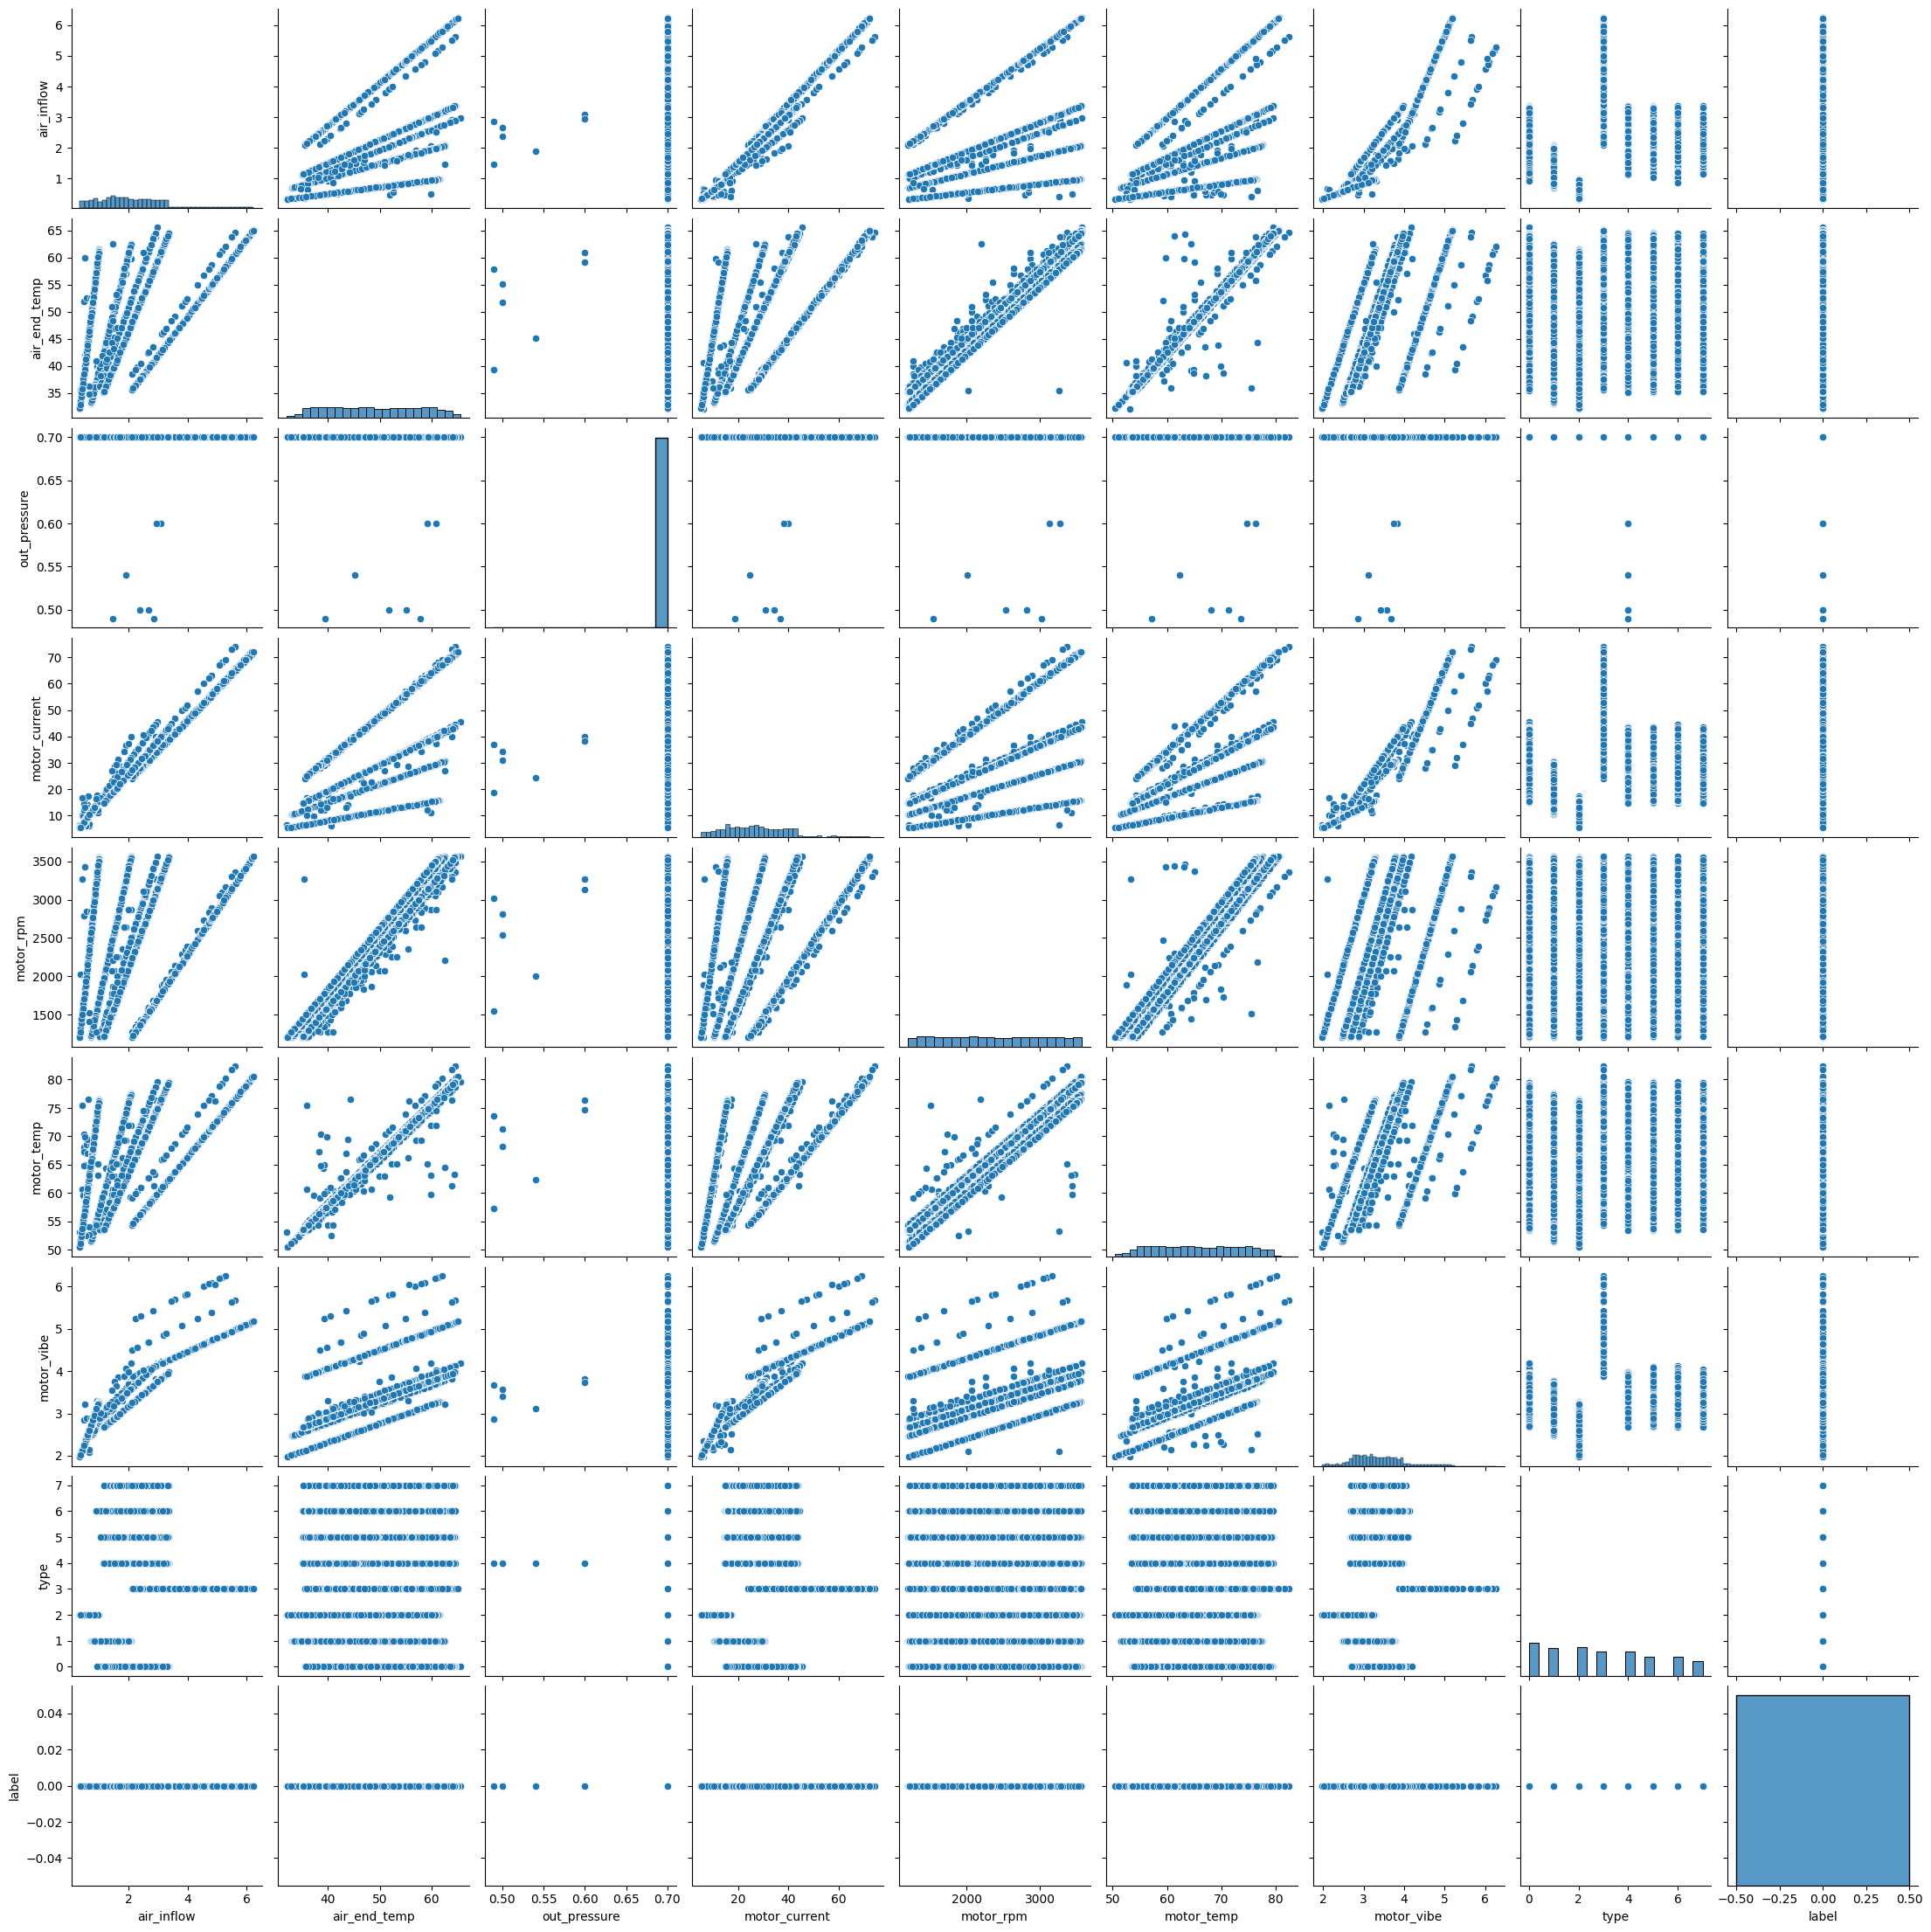

In [ ]:
test_df['label'] = test_pred
sns.pairplot(test_df[test_df['label'] == 0])

In [ ]:
scaler = RobustScaler(quantile_range=(25.0, 75.0))

scaled_train = scaler.fit_transform(train_x)
scaled_test = scaler.transform(test_x)

scaled_train = pd.DataFrame(scaled_train)
scaled_test = pd.DataFrame(scaled_test)

In [ ]:
num = 0
test_pred = np.zeros(len(test_df))
def IForest(train_type, test_type):
    scaled_train_type = scaler.fit_transform(train_type)
    scaled_test_type = scaler.fit_transform(test_type)
    dimesion_reducer = SparseRandomProjection(n_components=128,
                                          eps=0.1)

    scaled_train_type = dimesion_reducer.fit_transform(scaled_train_type)
    scaled_test_type = dimesion_reducer.transform(scaled_test_type)

    scaled_train_type = pd.DataFrame(scaled_train_type)
    scaled_test_type = pd.DataFrame(scaled_test_type)

    model = IsolationForest(n_estimators=300,
                            max_samples=0.8, 
                            max_features=0.7,
                            contamination=0.001,
                            verbose=0)
    model.fit(scaled_train_type)

    global num
    global test_pred

    test_pred[num:num+len(scaled_test_type)] = model.predict(scaled_test_type)
    num += len(scaled_test_type)
    
    return test_pred 

IForest(scaled_train_type_0, scaled_test_type_0)
IForest(scaled_train_type_1, scaled_test_type_1)
IForest(scaled_train_type_2, scaled_test_type_2)
IForest(scaled_train_type_3, scaled_test_type_3)
IForest(scaled_train_type_4, scaled_test_type_4)
IForest(scaled_train_type_5, scaled_test_type_5)
IForest(scaled_train_type_6, scaled_test_type_6)
IForest(scaled_train_type_7, scaled_test_type_7)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
pd.DataFrame(test_pred).value_counts()

 1.0    7287
-1.0     102
dtype: int64

In [ ]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [ ]:
test_pred = get_pred_label(test_pred)

In [ ]:
submit = pd.read_csv("/content/drive/MyDrive/AIFactory/answer_sample.csv")
submit.head()

type  label
0     0     -1
1     0     -1
2     0     -1
3     0     -1
4     0     -1

In [ ]:
submit['label'] = test_pred
submit.label.value_counts()

0.0    7287
1.0     102
Name: label, dtype: int64

In [ ]:
submit.to_csv("/content/drive/MyDrive/AIFactory/submit5.csv", index = False)

In [ ]:
# 샘플 데이터 및 가까운 벡터를 평면에 플로팅하기
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 캔버스 사이즈 정의 및 타이틀 작성하기
plt.figure(figsize=(12,8))
plt.title("Isolation Forest Outlier visualization edited by Clary K")

# 학습 데이터, 테스트 데이터, 결측값 데이터 각각 스캐터플로팅 하기
plt.contourf(xx, yy, Z, cmap=plt.cm.binary)
ob1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
ob2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='yellow',
                 s=20, edgecolor='k')
ab = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=30, edgecolor='k')

# X, y축 범위 지정 및 범례 지정해주기 
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([ob1, ob2, ab],
           ["training observations",
            "test observations", "new abnormal observations"],
           loc="upper left")
plt.show()




---



In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/AIFactory/train_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/AIFactory/test_data.csv")

# Auto Encoder
!pip install pyod            # normal install
!pip install --upgrade pyod  # or update if needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.01 # percentage of outliers


train_x = train_df   # Input Data
test_x = test_df

# 설비번호 별로 특성이 다름
# 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
# 설비 번호 1: 20HP
# 설비 번호 2: 10HP
# 설비 번호 3: 50HP

# 설비번호: (0,4,5,6,7) / 1 / 2 / 3  4가지로 분류

def type_split(Data):
    type_04567 = Data.loc[Data["type"].isin([0,4,5,6,7])]
    type_1 = Data.loc[Data["type"] == 1]
    type_2 = Data.loc[Data["type"] == 2]
    type_3 = Data.loc[Data["type"] == 3]
    
    return type_04567, type_1, type_2, type_3

train_type_04567, train_type_1, train_type_2, train_type_3 = type_split(train_x)
test_type_04567, test_type_1, test_type_2, test_type_3 = type_split(test_x)
print("train_type")
print(train_type_04567.shape, train_type_1.shape, train_type_2.shape, train_type_3.shape)
print(" ")
print("test_type")
print(test_type_04567.shape, test_type_1.shape, test_type_2.shape, test_type_3.shape)
print(" ")

# 정규화 + 모델링 + 예측 함수

def Scaler(train_type, test_type):
    # MinMaxScaler()
    scaler = MinMaxScaler()
    scaled_train_type = scaler.fit_transform(train_type)
    scaled_test_type = scaler.fit_transform(test_type)

    scaled_train_type = pd.DataFrame(scaled_train_type)
    scaled_test_type = pd.DataFrame(scaled_test_type)
    
    # # dimension_reducer
    # dimesion_reducer = SparseRandomProjection(n_components=8,
    #                                       eps=0.1)
    # scaled_train_type = dimesion_reducer.fit_transform(scaled_train_type)
    # scaled_test_type = dimesion_reducer.transform(scaled_test_type)

    # scaled_train_type = pd.DataFrame(scaled_train_type)
    # scaled_test_type = pd.DataFrame(scaled_test_type)

    return scaled_train_type, scaled_test_type

scaled_train_type_04567, scaled_test_type_04567 = Scaler(train_type_04567,test_type_04567)
scaled_train_type_1, scaled_test_type_1 = Scaler(train_type_1, test_type_1)
scaled_train_type_2, scaled_test_type_2 = Scaler(train_type_2, test_type_2)
scaled_train_type_3, scaled_test_type_3 = Scaler(train_type_3, test_type_3)
print("scaled_train_type")
print(scaled_train_type_04567.shape, scaled_train_type_1.shape, scaled_train_type_2.shape, scaled_train_type_3.shape)
print(" ")
print("scaled_test_type")
print(scaled_test_type_04567.shape, scaled_test_type_1.shape, scaled_test_type_2.shape, scaled_test_type_3.shape)
print(" ")


# 모델링 + 예측
test_pred = np.zeros(len(test_df))  
from pyod.models.auto_encoder import AutoEncoder
atcdr_04567 = AutoEncoder(contamination=0.005, hidden_neurons =[4, 4], epochs=200)
atcdr_04567.fit(scaled_train_type_04567)      
test_pred[:1296] = atcdr_04567.predict(scaled_test_type_04567)[:1296]
test_pred[4419:] = atcdr_04567.predict(scaled_test_type_04567)[1296:]
num = 1296

atcdr_1 = AutoEncoder(contamination=0.005, hidden_neurons =[4, 4], epochs=200)
atcdr_1.fit(scaled_train_type_1)
test_pred[num:num+len(scaled_test_type_1)] = atcdr_1.predict(scaled_test_type_1)
num += len(scaled_train_type_1)

atcdr_2 = AutoEncoder(contamination=0.005, hidden_neurons =[4, 4], epochs=200)
atcdr_2.fit(scaled_train_type_2)
test_pred[num:num+len(scaled_test_type_2)] = atcdr_2.predict(scaled_test_type_2)
num += len(scaled_train_type_2)

atcdr_3 = AutoEncoder(contamination=0.005, hidden_neurons =[4, 4], epochs=200)
atcdr_3.fit(scaled_train_type_3)
test_pred[num:num+len(scaled_test_type_3)] = atcdr_3.predict(scaled_test_type_3)

print(pd.DataFrame(test_pred).value_counts())

# def get_pred_label(model_pred):
#     # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
#     model_pred = np.where(model_pred == 1.0, 0, model_pred)
#     model_pred = np.where(model_pred == 0.0, 1, model_pred)
#     return model_pred

# test_pred = get_pred_label(test_pred)
submit = pd.read_csv("/content/drive/MyDrive/AIFactory/answer_sample.csv")
submit['label'] = test_pred
submit.loc[submit.label == 0, 'label'] = 2
submit.loc[submit.label == 1, 'label'] = 0
submit.loc[submit.label == 2, 'label'] = 1

print(submit.label.value_counts())

# submit.to_csv("/content/drive/MyDrive/AIFactory/submit_a.csv", index = False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
train_type
(1422, 8) (369, 8) (366, 8) (306, 8)
 
test_type
(4266, 8) (1107, 8) (1098, 8) (918, 8)
 
scaled_train_type
(1422, 8) (369, 8) (366, 8) (306, 8)
 
scaled_test_type
(4266, 8) (1107, 8) (1098, 8) (918, 8)
 
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 8)                 72        
                                                                 
 dropout_100 (Dropout)       (None, 8)                 0         
                                                                 
 dense_126 (Dense)           (None, 8)                 72        
                                                                 
 dropout_101 (Dropout)       (None,

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/AIFactory/train_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/AIFactory/test_data.csv")

# Auto Encoder
# !pip install pyod            # normal install
# !pip install --upgrade pyod  # or update if needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train dataset, Test dataset은 Label이 존재하지 않음
train_x = train_df # Input Data
test_x = test_df

# 설비 번호 별로 데이터 분류
def type_split(Data):
    type_0 = Data.loc[Data["type"] == 0]
    type_1 = Data.loc[Data["type"] == 1]
    type_2 = Data.loc[Data["type"] == 2]
    type_3 = Data.loc[Data["type"] == 3]
    type_4 = Data.loc[Data["type"] == 4]
    type_5 = Data.loc[Data["type"] == 5]
    type_6 = Data.loc[Data["type"] == 6]
    type_7 = Data.loc[Data["type"] == 7]
    return type_0, type_1, type_2, type_3, type_4, type_5, type_6, type_7

train_type_0, train_type_1, train_type_2, train_type_3, train_type_4, train_type_5, train_type_6, train_type_7 = type_split(train_x)
test_type_0, test_type_1, test_type_2, test_type_3, test_type_4, test_type_5, test_type_6, test_type_7 = type_split(test_x)

print(train_type_0.shape, train_type_1.shape, train_type_2.shape, train_type_3.shape, train_type_4.shape, train_type_5.shape, train_type_6.shape, train_type_7.shape)

print(test_type_0.shape, test_type_1.shape, test_type_2.shape, test_type_3.shape, test_type_4.shape, test_type_5.shape, test_type_6.shape, test_type_7.shape)

# 정규화 + 모델링 + 예측 함수

num = 0
test_pred = np.zeros(len(test_df))
def model_auto(train_type, test_type):
    # MinMaxScaler()
    scaler = MinMaxScaler()
    scaled_train_type = scaler.fit_transform(train_type)
    scaled_test_type = scaler.fit_transform(test_type)

    scaled_train_type = pd.DataFrame(scaled_train_type)
    scaled_test_type = pd.DataFrame(scaled_test_type)
    
    # # dimension_reducer
    # dimesion_reducer = SparseRandomProjection(n_components=8,
    #                                       eps=0.1)
    # scaled_train_type = dimesion_reducer.fit_transform(scaled_train_type)
    # scaled_test_type = dimesion_reducer.transform(scaled_test_type)

    # scaled_train_type = pd.DataFrame(scaled_train_type)
    # scaled_test_type = pd.DataFrame(scaled_test_type)

    from pyod.models.auto_encoder import AutoEncoder
    atcdr = AutoEncoder(contamination=0.05, hidden_neurons=[4,4], epochs=200)
    atcdr.fit(scaled_train_type)  

    global num
    global test_pred

    test_pred[num:num+len(scaled_test_type)] = atcdr.predict(scaled_test_type)
    num += len(scaled_test_type)
    
    return test_pred 

model_auto(train_type_0, test_type_0)
model_auto(train_type_1, test_type_1)
model_auto(train_type_2, test_type_2)
model_auto(train_type_3, test_type_3)
model_auto(train_type_4, test_type_4)
model_auto(train_type_5, test_type_5)
model_auto(train_type_6, test_type_6)
model_auto(train_type_7, test_type_7)

print(pd.DataFrame(test_pred).value_counts())

# def get_pred_label(model_pred):
#     # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
#     model_pred = np.where(model_pred == 1.0, 0, model_pred)
#     model_pred = np.where(model_pred == 0.0, 1, model_pred)
#     return model_pred

# test_pred = get_pred_label(test_pred)
submit = pd.read_csv("/content/drive/MyDrive/AIFactory/answer_sample.csv")
submit['label'] = test_pred
submit.loc[submit.label == 0, 'label'] = 2
submit.loc[submit.label == 1, 'label'] = 0
submit.loc[submit.label == 2, 'label'] = 1

print(submit.label.value_counts())

# submit.to_csv("/content/drive/MyDrive/AIFactory/submit_a7.csv", index = False)

(432, 8) (369, 8) (366, 8) (306, 8) (306, 8) (249, 8) (249, 8) (186, 8)
(1296, 8) (1107, 8) (1098, 8) (918, 8) (918, 8) (747, 8) (747, 8) (558, 8)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 8)                 72        
                                                                 
 dropout_68 (Dropout)        (None, 8)                 0         
                                                                 
 dense_86 (Dense)            (None, 8)                 72        
                                                                 
 dropout_69 (Dropout)        (None, 8)                 0         
                                                                 
 dense_87 (Dense)            (None, 4)                 36        
                                                                 
 dropout_70 (Dropout)        (None, 4)